# Quantum Finance Lab · Notebook 01
## Classical Portfolio Optimization (no quantum yet)

*Goal*: build intuition for portfolio choice with the **mean–variance** model.
*Audience*: readers new to quant finance and quantum computing.
*Outcome*: compute baseline allocations, an optimized portfolio, and the efficient frontier.

**Roadmap**
1. Setup and toy data  
2. Turn prices into returns  
3. Baselines: equal weight and single-asset extremes  
4. Mean–variance optimization (unconstrained, simple math)  
5. No-short optional variant (QP)  
6. Efficient frontier and plots  
7. What these results mean and limits of the model  
8. What we will quantize next time


# 1) Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
plt.rcParams["figure.figsize"] = (6.5, 4.0)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
plt.rcParams["figure.figsize"] = (6.5, 4.0)


## 2) Toy monthly price table (12 months). Rows = time, Cols = assets.

* We start with **toy monthly prices** for 4 assets (A, B, C, D).  
* Replace these with your own data later.  
* Using toy numbers keeps the logic transparent.


In [2]:

dates = pd.date_range("2023-01-31", periods=12, freq="ME")
prices = pd.DataFrame(
    {
        "A": [100,102,101,103,105,104,106,108,109,111,112,113],
        "B": [ 50, 49, 50, 52, 51, 53, 55, 56, 57, 58, 60, 61],
        "C": [ 80, 81, 82, 82, 84, 85, 86, 87, 88, 89, 91, 92],
        "D": [120,121,119,118,120,122,121,123,124,126,127,129],
    },
    index=dates
)
prices.head()


,A,B,C,D
2023-01-31,100,50,80,120
2023-02-28,102,49,81,121
2023-03-31,101,50,82,119
2023-04-30,103,52,82,118
2023-05-31,105,51,84,120


## 3) From prices to returns

* Use **simple returns**: $ r_t = \frac{P_t}{P_{t-1}} - 1 $.  
* Compute sample **mean returns** and **covariance**.  
* These are the core inputs for mean–variance.


In [3]:
returns = prices.pct_change().dropna()
mu = returns.mean()               # vector of mean returns
Sigma = returns.cov()             # covariance matrix
asset_names = list(returns.columns)

mu, Sigma


(A    0.011231
 B    0.018442
 C    0.012805
 D    0.006663
 dtype: float64,
           A         B         C         D
 A  0.000128 -0.000082 -0.000003  0.000025
 B -0.000082  0.000443 -0.000058 -0.000091
 C -0.000003 -0.000058  0.000040  0.000030
 D  0.000025 -0.000091  0.000030  0.000147)

## 4) Baselines

* **Equal weight**: spread capital evenly.  
* **All-in single assets**: reference points for risk/return extremes.  
* We will compare these to the optimized solution.


In [4]:
def portfolio_stats(weights, mu, Sigma):
    """Return (exp_return, volatility, variance)."""
    w = np.asarray(weights).reshape(-1, 1)
    exp_ret = (w.T @ mu.values.reshape(-1,1)).item()
    var = (w.T @ Sigma.values @ w).item()
    vol = np.sqrt(var)
    return exp_ret, vol, var

n = len(asset_names)
w_eq = np.ones(n) / n
print(w_eq)
base = {}
base["Equal weight"] = w_eq
for i, a in enumerate(asset_names):
    w_one = np.zeros(n); w_one[i] = 1.0
    base[f"100% {a}"] = w_one

rows = []
for label, w in base.items():
    er, vol, _ = portfolio_stats(w, mu, Sigma)
    rows.append((label, w, er, vol))

baseline_df = pd.DataFrame(rows, columns=["Portfolio","Weights","ExpReturn","Volatility"])
baseline_df

[0.25 0.25 0.25 0.25]


,Portfolio,Weights,ExpReturn,Volatility
0,Equal weight,"[0.25, 0.25, 0.25, 0.25]",0.012285,0.004995
1,100% A,"[1.0, 0.0, 0.0, 0.0]",0.011231,0.011304
2,100% B,"[0.0, 1.0, 0.0, 0.0]",0.018442,0.021050
3,100% C,"[0.0, 0.0, 1.0, 0.0]",0.012805,0.006343
4,100% D,"[0.0, 0.0, 0.0, 1.0]",0.006663,0.012114


## 4. Mean–variance objective (unconstrained, simple math)

We minimize **risk minus reward**:
$$
\min_w\; \tfrac{1}{2} w^\top \Sigma w - \lambda\, \mu^\top w
$$
Subject to a single **budget** constraint:
$$
\mathbf{1}^\top w = 1
$$
* $\lambda > 0$ is a **risk-aversion** knob.  
* This closed-form solution allows **shorting** since we did not add nonnegativity.

**Closed form** with one equality:
$$
w^* = \Sigma^{-1}\big(\lambda\,\mu + \gamma\,\mathbf{1}\big),
$$
where $\gamma$ is chosen so that $\mathbf{1}^\top w^* = 1$.


In [5]:
# Unconstrained optimizer (allows shorting)
def mean_variance_unconstrained(mu, Sigma, risk_aversion=5.0):
    """
    Solve min 0.5 w^T Σ w - λ μ^T w  s.t. 1^T w = 1
    Returns optimal weights.
    """
    mu = mu.values.reshape(-1, 1)
    ones = np.ones_like(mu)
    Sigma_inv = np.linalg.inv(Sigma.values)

    lam = float(risk_aversion)
    # w = Σ^{-1}(λ μ + γ 1), enforce 1^T w = 1 to find γ
    A = ones.T @ Sigma_inv @ ones
    B = ones.T @ Sigma_inv @ mu
    # 1^T w = 1 → 1^T Σ^{-1}(λ μ + γ 1) = 1 → lam*B + γ*A = 1
    gamma = (1 - lam*B.item()) / A.item()
    w = Sigma_inv @ (lam*mu + gamma*ones)
    return w.ravel()

def tangency_weights(mu, Sigma, rf=0.0):
    S = Sigma.values
    mu_v = mu.values.reshape(-1,1)
    ones = np.ones_like(mu_v)
    x = np.linalg.solve(S, mu_v - rf * ones)
    denom = (ones.T @ x).item()
    w = x / denom
    return w.ravel()

w_star = tangency_weights(mu, Sigma, rf=0.0)
w_star, w_star.sum()


(array([ 0.222 ,  0.1668,  0.6202, -0.009 ]), np.float64(0.9999999999999998))

## 6) Inspect the optimized portfolio

* Check weights, expected return, and volatility.  
* Compare against baselines.


In [6]:
er_star, vol_star, _ = portfolio_stats(w_star, mu, Sigma)

summary = baseline_df.copy()
summary.loc[len(summary)] = [
    "Optimized (unconstrained)",
    w_star,
    er_star,
    vol_star
]
summary


,Portfolio,Weights,ExpReturn,Volatility
0,Equal weight,"[0.25, 0.25, 0.25, 0.25]",0.012285,0.004995
1,100% A,"[1.0, 0.0, 0.0, 0.0]",0.011231,0.011304
2,100% B,"[0.0, 1.0, 0.0, 0.0]",0.018442,0.021050
3,100% C,"[0.0, 0.0, 1.0, 0.0]",0.012805,0.006343
4,100% D,"[0.0, 0.0, 0.0, 1.0]",0.006663,0.012114
5,Optimized (unconstrained),"[0.22203203571450042, 0.16679227967870422, 0.6...",0.013451,0.003877


## 7) No-short variant (Quadratic Program)

* If you want **no shorting**, add $ w \ge 0 $.  
* This becomes a **quadratic program**.  
* We can use `cvxpy` for a compact formulation.

> If `cvxpy` is not installed, run `pip install cvxpy`.


In [7]:
import cvxpy as cp

def mean_variance_noshort(mu, Sigma, risk_aversion=5.0):
    mu_v = mu.values
    Sigma_m = Sigma.values
    n = len(mu_v)
    w = cp.Variable(n)
    objective = 0.5 * cp.quad_form(w, Sigma_m) - risk_aversion * mu_v @ w
    constraints = [cp.sum(w) == 1, w >= 0]
    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    return w.value

w_ns = mean_variance_noshort(mu, Sigma, risk_aversion=5.0)
er_ns, vol_ns, _ = portfolio_stats(w_ns, mu, Sigma)

w_ns, er_ns, vol_ns


(array([-0.,  1., -0., -0.]),
 0.018441925031008236,
 np.float64(0.021050203976225975))

## 8) Efficient frontier (parametric sweep)

* Vary the **risk-aversion** $\lambda$ to trace the frontier.  
* Each point is an optimal portfolio for that $\lambda$.  
* This is for the **unconstrained** case to keep code simple.


In [8]:
# Frontier by target return (analytic)
S = Sigma.values
mu_v = mu.values.reshape(-1,1)
ones = np.ones_like(mu_v)
# Pre-solve Sx = b instead of explicit inverse
x1 = np.linalg.solve(S, ones)
xmu = np.linalg.solve(S, mu_v)
A = (ones.T @ x1).item()
B = (ones.T @ xmu).item()
C = (mu_v.T @ xmu).item()

E_tan = C / B if B != 0 else float(mu.mean())
targets = np.linspace(min(float(mu.min()), E_tan), max(float(mu.max()), E_tan), 60)
pts = []
W = []
for r in targets:
    coef = np.array([[A, B],[B, C]])
    rhs = np.array([1.0, r])
    a, b = np.linalg.solve(coef, rhs)
    w = a * x1 + b * xmu
    er = (mu_v.T @ w).item()
    var = (w.T @ S @ w).item()
    vol = np.sqrt(var)
    pts.append((vol, er))
    W.append(w.ravel())
frontier = pd.DataFrame(pts, columns=["Vol","ExpReturn"])
frontier.head()


,Vol,ExpReturn
0,0.011797,0.006663
1,0.011469,0.006863
2,0.011143,0.007062
3,0.010817,0.007262
4,0.010493,0.007462


## 9) Plots

* Efficient frontier: volatility on x, expected return on y.  
* Show baselines and the optimized picks.


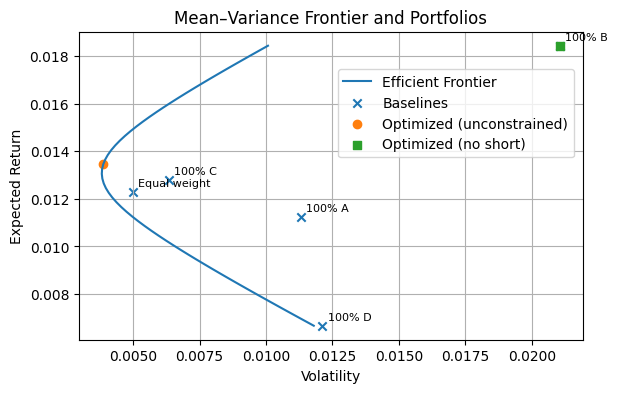

In [12]:
plt.figure()
plt.plot(frontier["Vol"], frontier["ExpReturn"], label="Efficient Frontier")
plt.scatter(baseline_df["Volatility"], baseline_df["ExpReturn"], marker="x", label="Baselines")
plt.scatter([vol_star], [er_star], marker="o", label="Optimized (unconstrained)")

if w_ns is not None:
    plt.scatter([vol_ns], [er_ns], marker="s", label="Optimized (no short)")

for i, row in baseline_df.iterrows():
    plt.annotate(row["Portfolio"], (row["Volatility"], row["ExpReturn"]), xytext=(4,4), textcoords="offset points", fontsize=8)

plt.xlabel("Volatility")
plt.ylabel("Expected Return")
plt.title("Mean–Variance Frontier and Portfolios")
plt.grid(True)
plt.legend(loc="upper left", bbox_to_anchor=(0.5, 0.9))
plt.show()

## 10) Interpret the results

* The **frontier** shows the best trade-offs you can get from these assets under the model.  
* The **optimized** point balances reward and risk using your chosen $\lambda$.  
* The **no-short** constraint often shifts weights toward safer assets and raises volatility slightly for the same return.

##  Limits of the mean–variance model

* Uses **sample means and covariances** which can be noisy for small samples.  
* Assumes **quadratic utility** or **normally distributed** returns.  
* Sensitive to **outliers** and **look-ahead bias** if you are not careful.  
* In practice, people regularize, shrink covariances, or add constraints.


##  What we will quantize next time

* We will map the **discrete** version of this problem to a **QUBO** (quadratic unconstrained binary optimization).  
* Then we can run **QAOA** or related methods in Qiskit to compare with the classical baselines here.  
* You now have a clear classical reference to benchmark against.


## (Appendix) Quick “what is what” glossary

* **Return**: relative price change over a period.  
* **Expected return**: average of returns across time.  
* **Covariance**: how two assets move together.  
* **Volatility**: square root of variance; a risk proxy in this model.  
* **Risk-aversion \(\lambda\)**: higher values penalize risk more.  
* **Shorting**: allowing negative weights. No-short sets weights \(\ge 0\).
